In [4]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

from disparity_ssd import disparity_ssd
from disparity_ncorr import disparity_ncorr

plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

In [5]:
def imsave(image: np.ndarray, path):
    norm_image = (((image - image.min()) / (image.max() - image.min())) * 255).astype(np.uint8)
    cv2.imwrite(path, norm_image)

# Part 1

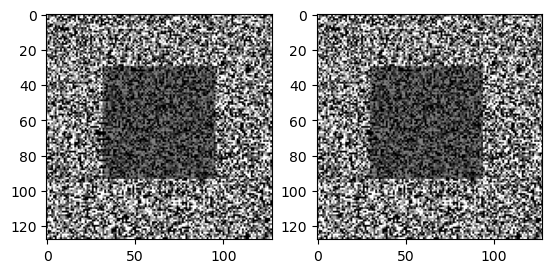

In [23]:
L = cv2.imread(os.path.join('input', 'pair0-L.png'), 0) * (1.0 / 255.0)  # grayscale, [0, 1]
R = cv2.imread(os.path.join('input', 'pair0-R.png'), 0) * (1.0 / 255.0)

plt.subplot(121)
plt.imshow(L)
plt.subplot(122)
plt.imshow(R)
plt.show()

In [24]:
D_L = disparity_ssd(L, R)
D_R = disparity_ssd(R, L)

100%|██████████| 128/128 [00:10<00:00, 12.26it/s]


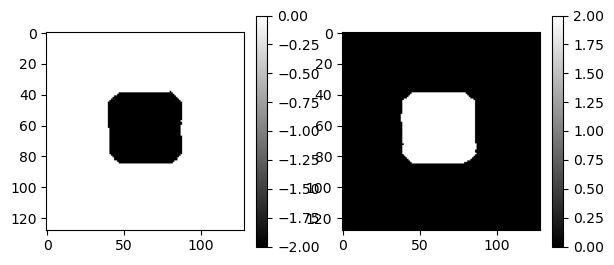

In [37]:
plt.figure(figsize=(7, 3))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

imsave(D_L, 'output/ps2-1-a-1.png')
imsave(D_R, 'output/ps2-1-a-2.png')

This looks pretty much perfect.

# Part 2

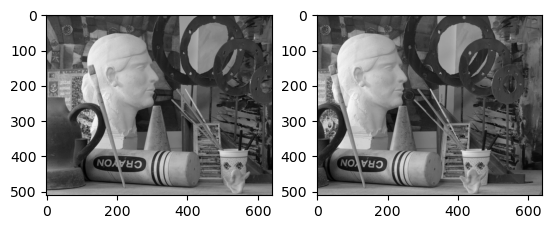

In [3]:
L = cv2.imread(os.path.join('input', 'pair1-L.png'), 0) * (1.0 / 255.0)
R = cv2.imread(os.path.join('input', 'pair1-R.png'), 0) * (1.0 / 255.0)

plt.subplot(121)
plt.imshow(L)
plt.subplot(122)
plt.imshow(R)
plt.show()

In [42]:
D_L = disparity_ssd(L, R, w=11)
D_R = disparity_ssd(R, L, w=11)

100%|██████████| 511/511 [02:51<00:00,  2.99it/s]


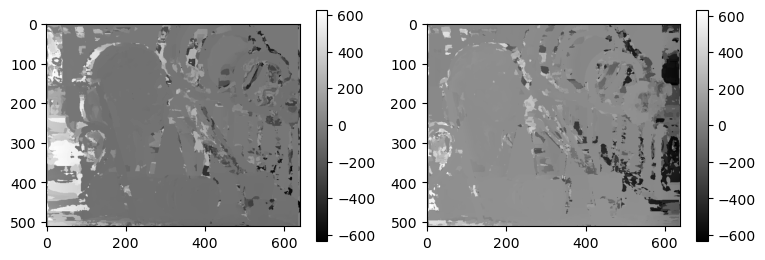

In [43]:
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

imsave(D_L, 'output/ps2-2-a-1.png')
imsave(D_R, 'output/ps2-2-a-2.png')

This doesn't look great, but we can sort of see the underlying structure that's visible in the image.

# Part 3 a

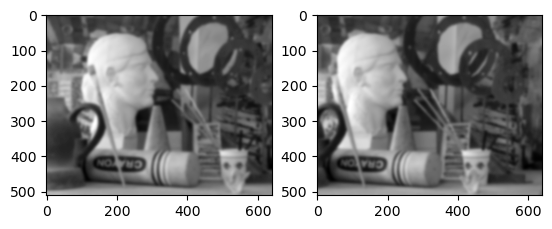

In [4]:
L_blur = cv2.GaussianBlur(L, (21, 21), 0)
R_blur = cv2.GaussianBlur(R, (21, 21), 0)

plt.subplot(121)
plt.imshow(L_blur)
plt.subplot(122)
plt.imshow(R_blur)
plt.show()

In [45]:
D_L_blur = disparity_ssd(L_blur, R_blur, w=11)
D_R_blur = disparity_ssd(R_blur, L_blur, w=11)

100%|██████████| 511/511 [03:40<00:00,  2.31it/s]


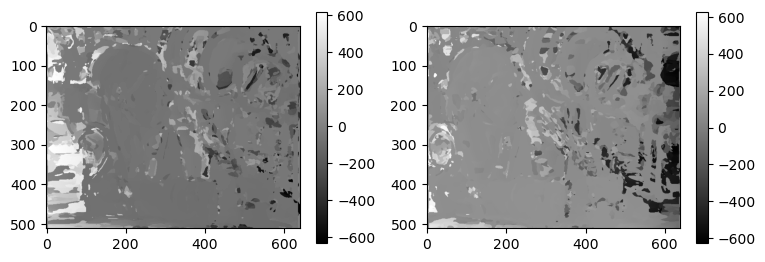

In [46]:
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(D_L_blur)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_blur)
plt.colorbar()
plt.show()

imsave(D_L_blur, 'output/ps2-3-a-1.png')
imsave(D_R_blur, 'output/ps2-3-a-2.png')

This looks much worse, the structure is basically gone.

# Part 3 b

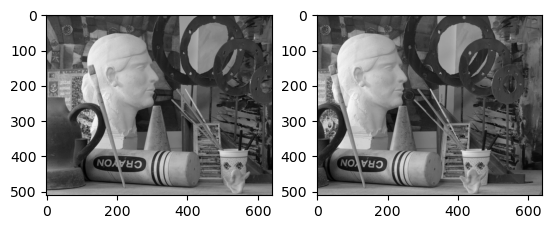

In [5]:
L_cont = L * 1.1
R_cont = R * 1.1

plt.subplot(121)
plt.imshow(L_cont)
plt.subplot(122)
plt.imshow(R_cont)
plt.show()

In [48]:
D_L_cont = disparity_ssd(L_cont, R_cont, w=11)
D_R_cont = disparity_ssd(R_cont, L_cont, w=11)

100%|██████████| 511/511 [03:09<00:00,  2.70it/s]


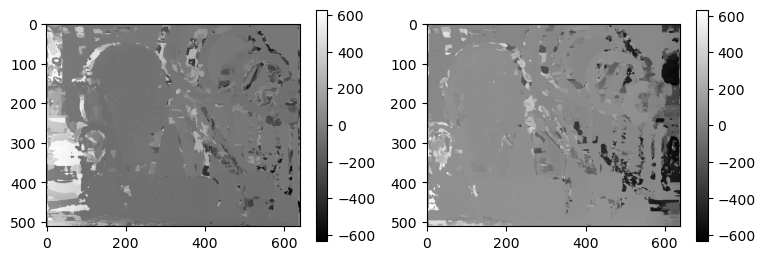

In [49]:
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.imshow(D_L_cont)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_cont)
plt.colorbar()
plt.show()

imsave(D_L_blur, 'output/ps2-3-b-1.png')
imsave(D_R_blur, 'output/ps2-3-b-2.png')

Again, this looks quite bad.

# Part 4 a

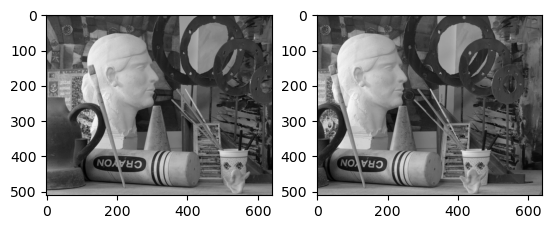

In [6]:
L = cv2.imread(os.path.join('input', 'pair1-L.png'), 0) * (1.0 / 255.0)  # grayscale, [0, 1]
R = cv2.imread(os.path.join('input', 'pair1-R.png'), 0) * (1.0 / 255.0)

plt.subplot(121)
plt.imshow(L)
plt.subplot(122)
plt.imshow(R)
plt.show()

In [17]:
import cv2
import numpy as np
from tqdm import trange


def disparity_ncorr(L, R, w=11, d_max=100):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L

    Returns: Disparity map, same size as L, R
    """

    assert w % 2 == 1
    n_rows, n_cols = L.shape
    D = np.empty_like(L)
    pad_L = np.pad(L, w // 2).astype(np.float32)
    pad_R = np.pad(R, w // 2).astype(np.float32)

    L_windows = np.lib.stride_tricks.sliding_window_view(pad_L, (w, w))
    R_rows = np.lib.stride_tricks.sliding_window_view(pad_R, w, axis=0).transpose([0, 2, 1])

    for i in trange(n_rows):
        for j in range(n_cols):
            start = max(j - d_max, 0)
            R_row = R_rows[i, :, start:j + d_max]
            corr_matrix = cv2.matchTemplate(R_row, L_windows[i, j], cv2.TM_CCOEFF_NORMED)[0]
            matches_idx = np.argmax(corr_matrix) + start
            D[i, j] = matches_idx - j
    return D


In [22]:
D_L = disparity_ncorr(L, R, w=21, d_max=100)
D_R = disparity_ncorr(R, L, w=21, d_max=100)

100%|██████████| 511/511 [00:25<00:00, 20.31it/s]


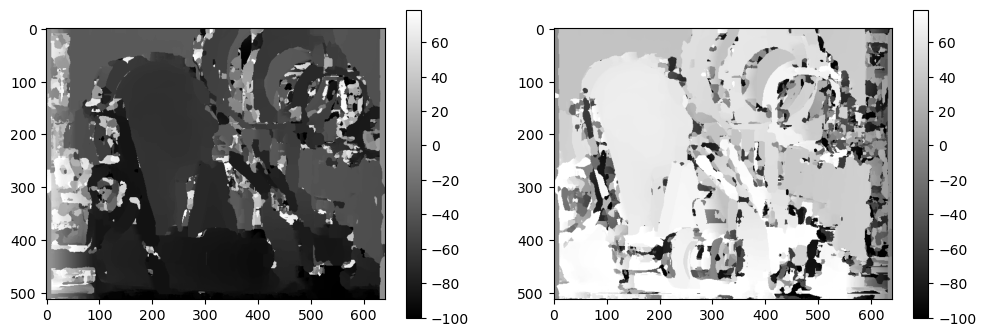

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

imsave(D_L, 'output/ps2-4-a-1.png')
imsave(D_R, 'output/ps2-4-a-2.png')